In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

#### Loading Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

In [3]:
train_dataset = datasets.ImageFolder('split_by_presence/train', transform=transform)
val_dataset = datasets.ImageFolder('split_by_presence/val', transform=transform)
test_dataset = datasets.ImageFolder('split_by_presence/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


### Training Model

In [4]:
# Define the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification output
model = model.to(device)

C:\Users\jmlim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jmlim/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 11.7MB/s]


In [5]:
# Define loss function, optimizer and learning rate
criterion = nn.BCEWithLogitsLoss()  # Good for binary output from linear layer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
def evaluate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(dataloader)
    val_accuracy = correct / total
    return avg_val_loss, val_accuracy

In [7]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, save_best=True):
    best_val_acc = 0.0  # To track the best validation accuracy
    best_model_wts = model.state_dict()  # To store the best model weights

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation loop
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_accuracy:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = model.state_dict()  # Save the current model weights

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)

    # Plot the training history (Loss and Accuracy)
    plot_training_history(history)

    return model, history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Evaluation of the Model


Epoch 1/15


Training: 100%|██████████| 2884/2884 [11:25<00:00,  4.21it/s]


Train Loss: 0.0102 | Train Acc: 0.9964
Val   Loss: 0.0039 | Val   Acc: 0.9986

Epoch 2/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.68it/s]


Train Loss: 0.0030 | Train Acc: 0.9991
Val   Loss: 0.0028 | Val   Acc: 0.9988

Epoch 3/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.70it/s]


Train Loss: 0.0020 | Train Acc: 0.9994
Val   Loss: 0.0012 | Val   Acc: 0.9995

Epoch 4/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.72it/s]


Train Loss: 0.0020 | Train Acc: 0.9993
Val   Loss: 0.0009 | Val   Acc: 0.9996

Epoch 5/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.70it/s]


Train Loss: 0.0015 | Train Acc: 0.9995
Val   Loss: 0.0032 | Val   Acc: 0.9992

Epoch 6/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.71it/s]


Train Loss: 0.0013 | Train Acc: 0.9996
Val   Loss: 0.0014 | Val   Acc: 0.9992

Epoch 7/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.72it/s]


Train Loss: 0.0007 | Train Acc: 0.9998
Val   Loss: 0.0017 | Val   Acc: 0.9994

Epoch 8/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.72it/s]


Train Loss: 0.0010 | Train Acc: 0.9996
Val   Loss: 0.0011 | Val   Acc: 0.9996

Epoch 9/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.71it/s]


Train Loss: 0.0009 | Train Acc: 0.9996
Val   Loss: 0.0007 | Val   Acc: 0.9998

Epoch 10/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.71it/s]


Train Loss: 0.0010 | Train Acc: 0.9997
Val   Loss: 0.0025 | Val   Acc: 0.9992

Epoch 11/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.71it/s]


Train Loss: 0.0004 | Train Acc: 0.9999
Val   Loss: 0.0018 | Val   Acc: 0.9992

Epoch 12/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.70it/s]


Train Loss: 0.0006 | Train Acc: 0.9998
Val   Loss: 0.0006 | Val   Acc: 0.9998

Epoch 13/15


Training: 100%|██████████| 2884/2884 [04:07<00:00, 11.63it/s]


Train Loss: 0.0001 | Train Acc: 1.0000
Val   Loss: 0.0025 | Val   Acc: 0.9992

Epoch 14/15


Training: 100%|██████████| 2884/2884 [04:07<00:00, 11.66it/s]


Train Loss: 0.0008 | Train Acc: 0.9998
Val   Loss: 0.0010 | Val   Acc: 0.9998

Epoch 15/15


Training: 100%|██████████| 2884/2884 [04:06<00:00, 11.70it/s]


Train Loss: 0.0008 | Train Acc: 0.9998
Val   Loss: 0.0022 | Val   Acc: 0.9992


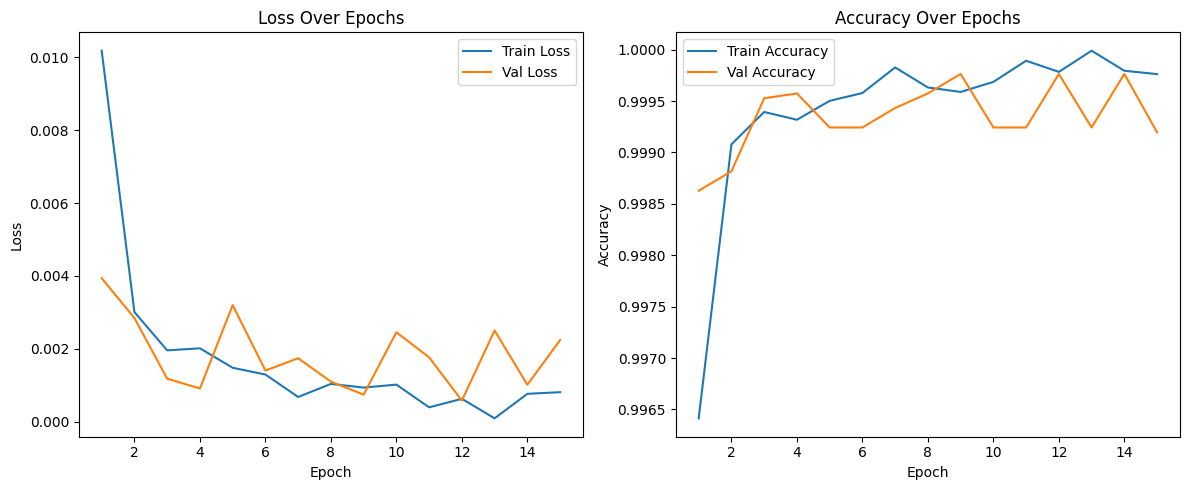

In [8]:
num_epochs = 15
best_model, epoch_history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs)

# Save the best model
torch.save(best_model.state_dict(), "best_piece_classifier.pt")